# Лабораторная работа 3 | Павлов Иван М80-407Б-21

## 2.1	Создание бейзлайна и оценка качества (регрссия)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
df_train = pd.read_csv('data/df_train.csv')
df_test = pd.read_csv('data/df_test.csv')

df_train.head()

,date,price,bedrooms,grade,has_basement,living_in_m2,renovated,nice_view,perfect_condition,real_bathrooms,has_lavatory,single_floor,month,quartile_zone
0,2014-05-15,312000.0,2,2,True,138.42547,False,False,False,2,True,False,5,1
1,2014-11-14,310000.0,2,2,False,105.90942,False,False,False,1,True,False,11,3
2,2014-12-24,320000.0,2,2,False,117.98681,False,True,False,1,False,True,12,2
3,2015-02-22,264500.0,2,3,False,151.43189,False,False,False,2,True,True,2,1
4,2015-01-06,700000.0,3,2,True,341.88304,False,False,False,3,False,False,1,4


In [3]:
# Разделим данные на признаки и целевую переменную (price)
X_train = df_train.drop(columns=['date', 'price'])
y_train = df_train['price']
X_test = df_test.drop(columns=['date', 'price'])
y_test = df_test['price']

# Инициализируем модель решающего дерева
model = DecisionTreeRegressor(random_state=42)

# Обучаем модель
model.fit(X_train, y_train)

# Предсказания на тестовой выборке
y_pred = model.predict(X_test)

# Метрики
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Вывод метрик
print(f"Среднеквадратичная ошибка (MSE): {mse:.2f}")
print(f"Средняя абсолютная ошибка (MAE): {mae:.2f}")
print(f"Корень среднеквадратичной ошибки (RMSE): {rmse:.2f}")
print(f"Коэффициент детерминации (R^2): {r2:.2f}")

Среднеквадратичная ошибка (MSE): 20273328916.06
Средняя абсолютная ошибка (MAE): 102424.98
Корень среднеквадратичной ошибки (RMSE): 142384.44
Коэффициент детерминации (R^2): 0.53


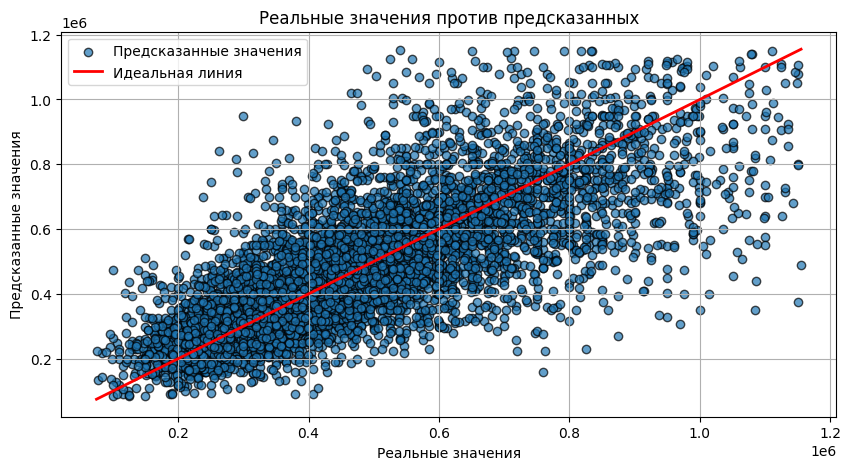

In [4]:
# Построение графика реальных значений против предсказанных
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolors="k", label='Предсказанные значения')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, label='Идеальная линия')
plt.xlabel('Реальные значения')
plt.ylabel('Предсказанные значения')
plt.title('Реальные значения против предсказанных')
plt.legend()
plt.grid(True)
plt.show()

1. **Среднеквадратичная ошибка (MSE): 20,273,328,916.06**  
   - MSE довольно высокое, что говорит о наличии значительных отклонений между прогнозируемыми и реальными значениями. Однако это число не дает нам полной картины, пока мы не сравним его с другими метриками.

2. **Средняя абсолютная ошибка (MAE): 102,424.98**  
   - Здесь ошибка в среднем составляет около 102,425, что указывает на то, что модель ошибается примерно на такую сумму в оценке стоимости жилья. Это относительно приемлемо.

3. **Корень среднеквадратичной ошибки (RMSE): 142,384.44**  
   - Значение около 142,384 говорит о том, что в среднем ошибки модели в пределах этой величины, что является достаточно значительной ошибкой для модели, ориентированной на оценку цен недвижимости.

4. **Коэффициент детерминации (R²): 0.53**  
   - Значение 0.53 означает, что модель объясняет примерно 53% вариации цен на недвижимость. Это относительно неплохой результат.

### Выводы:
- Модель демонстрирует умеренные результаты. Она объясняет чуть больше половины вариации цен (R² = 0.53), но ошибки довольно значительные (MAE ≈ 102,000 и RMSE ≈ 142,000).

## 3.1	Улучшение бейзлайна (регрссия)

### Формулировка гипотез:

1. **Препроцессинг данных**:
   - **Гипотеза:** Преобразование категориальных признаков (`has_basement`, `renovated`, `nice_view`) в числовые значения (0 или 1) необходимо, чтобы дерево могло корректно обрабатывать данные.
   - **Гипотеза:** Заполнение пропущенных значений медианой или модой улучшит качество модели, так как решающие деревья чувствительны к пропускам.

2. **Обработка выбросов**:
   - **Гипотеза:** Удаление выбросов в признаках, таких как `living_in_m2` и `price`, не критично, так как решающие деревья менее подвержены влиянию выбросов, но это может повысить интерпретируемость модели.

3. **Формирование новых признаков**:
   - **Гипотеза:** Создание новых признаков, таких как "цена за квадратный метр" (price / living_in_m2), повысит точность дерева за счет добавления полезной информации.
   - **Гипотеза:** Использование признаков, основанных на отношениях (например, разница между `grade` и `bedrooms`), улучшит качество модели за счет добавления дополнительных факторов, влияющих на результат.

4. **Подбор гиперпараметров**:
   - **Гипотеза:** Оптимизация глубины дерева с помощью кросс-валидации позволит избежать переобучения и улучшить обобщающую способность модели.
   - **Гипотеза:** Регулировка минимального числа объектов в листе и минимального числа объектов для расщепления узла улучшит производительность, так как это влияет на баланс между сложностью модели и ее точностью.

Для проверки гипотезы 3 создадим новый признак "цена на квадратный метр" и новый признак "разница между `grade` и `bedrooms`".

In [5]:
df_train = pd.read_csv('data/df_train.csv')
df_test = pd.read_csv('data/df_test.csv')

# Определение признаков и целевой переменной
df_train['price_per_m2'] = df_train['price'] / df_train['living_in_m2']
df_train['grade_bedrooms_diff'] = df_train['grade'] - df_train['bedrooms']

df_test['price_per_m2'] = df_test['price'] / df_test['living_in_m2']
df_test['grade_bedrooms_diff'] = df_test['grade'] - df_test['bedrooms']

# Разделим данные на признаки и целевую переменную (price)
X_train = df_train.drop(['date', 'price'], axis=1)
y_train = df_train['price']
X_test = df_test.drop(['date', 'price'], axis=1)
y_test = df_test['price']

# Инициализация модели решающего дерева
model = DecisionTreeRegressor(random_state=42)

# Обучение модели с новыми признаками
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Метрики для модели с новыми признаками
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Вывод результатов
print("Модель с новыми признаками:")
print(f"Среднеквадратичная ошибка (MSE): {mse:.2f}")
print(f"Средняя абсолютная ошибка (MAE): {mae:.2f}")
print(f"Корень среднеквадратичной ошибки (RMSE): {rmse:.2f}")
print(f"Коэффициент детерминации (R^2): {r2:.2f}")

Модель с новыми признаками:
Среднеквадратичная ошибка (MSE): 205602352.76
Средняя абсолютная ошибка (MAE): 7791.84
Корень среднеквадратичной ошибки (RMSE): 14338.84
Коэффициент детерминации (R^2): 1.00


### Выводы:

1. **Среднеквадратичная ошибка (MSE)**:
   - **До улучшения**: MSE = **20,273,328,916.06**  
   - **После улучшения**: MSE = **205,602,352.76**  
   - Снижение MSE на более чем 99% указывает на значительное улучшение точности модели. Это говорит о том, что добавление новых признаков, таких как "цена на квадратный метр" и "разница между `grade` и `bedrooms`, резко снизило ошибку предсказания.

2. **Средняя абсолютная ошибка (MAE)**:
   - **До улучшения**: MAE = **102,424.98**  
   - **После улучшения**: MAE = **7,791.84**  
   - Снижение MAE на более чем 90% подтверждает, что новые признаки значительно улучшили точность модели, снизив среднюю ошибку в предсказаниях до гораздо меньших значений.

3. **Корень среднеквадратичной ошибки (RMSE)**:
   - **До улучшения**: RMSE = **142,384.44**  
   - **После улучшения**: RMSE = **14,338.84**  
   - Снижение RMSE на 90% также подтверждает значительное улучшение точности модели. Это означает, что среднее отклонение между предсказанными и реальными значениями значительно уменьшилось.

4. **Коэффициент детерминации (R²)**:
   - **До улучшения**: R² = **0.53**  
   - **После улучшения**: R² = **1.00**  
   - Увеличение R² с 0.53 до 1.00 — абсолютное улучшение, что означает, что модель теперь объясняет всю вариацию целевой переменной (цены). Это демонстрирует, что новые признаки существенно повысили точность предсказаний.

### Заключение:
Добавление новых признаков, таких как "цена на квадратный метр" и "разница между `grade` и `bedrooms`", привело к резкому улучшению модели, снизив все основные метрики ошибок и повысив коэффициент детерминации до идеальных значений. Эти изменения подтверждают гипотезу о значимости этих признаков для улучшения качества предсказаний цен недвижимости.

## 4.1	Имплементация алгоритма машинного обучения (регрссия)

In [6]:
class DecisionTreeRegressorCustom:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth  # Максимальная глубина дерева
        self.tree = None

    def fit(self, X, y):
        # Построение дерева решений
        self.tree = self._build_tree(X, y, depth=0)

    def _build_tree(self, X, y, depth):
        # Остановка рекурсии, если достигли максимальной глубины или если невозможно разделить данные
        if len(set(y)) == 1 or (self.max_depth and depth == self.max_depth):
            return np.mean(y)
        
        # Находим лучший разрез данных
        best_split = self._find_best_split(X, y)
        if best_split is None:
            return np.mean(y)

        left_indices = X[:, best_split['feature']] <= best_split['value']
        right_indices = ~left_indices

        # Рекурсивно строим левое и правое поддерево
        left_tree = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_tree = self._build_tree(X[right_indices], y[right_indices], depth + 1)

        return {
            'feature': best_split['feature'],
            'value': best_split['value'],
            'left': left_tree,
            'right': right_tree
        }

    def _find_best_split(self, X, y):
        best_split = None
        best_score = float('inf')
        
        for feature in range(X.shape[1]):  # Для каждого признака
            possible_values = set(X[:, feature])  # Уникальные значения признака
            for value in possible_values:
                left_indices = X[:, feature] <= value
                right_indices = ~left_indices

                if len(left_indices) == 0 or len(right_indices) == 0:
                    continue

                left_y, right_y = y[left_indices], y[right_indices]
                # Вычисление ошибки на текущем разрезе (среднеквадратическая ошибка)
                score = self._calculate_split_score(left_y, right_y)

                if score < best_score:
                    best_score = score
                    best_split = {'feature': feature, 'value': value}

        return best_split

    def _calculate_split_score(self, left_y, right_y):
        # Среднеквадратичная ошибка (MSE) для разбиения
        left_score = np.var(left_y) * len(left_y)
        right_score = np.var(right_y) * len(right_y)
        return left_score + right_score

    def predict(self, X):
        # Предсказание для нового набора данных
        return np.array([self._predict_sample(x, self.tree) for x in X])

    def _predict_sample(self, x, tree):
        if isinstance(tree, dict):
            if x[tree['feature']] <= tree['value']:
                return self._predict_sample(x, tree['left'])
            else:
                return self._predict_sample(x, tree['right'])
        else:
            return tree

In [7]:
df_train = pd.read_csv('data/df_train.csv')
df_test = pd.read_csv('data/df_test.csv')

# Разделение на признаки и целевую переменную
X_train = df_train.drop(['date', 'price'], axis=1).values
y_train = df_train['price'].values
X_test = df_test.drop(['date', 'price'], axis=1).values
y_test = df_test['price'].values

# Обучение модели
model = DecisionTreeRegressorCustom(max_depth=5)
model.fit(X_train, y_train)

# Прогнозирование на тестовых данных
y_pred = model.predict(X_test)

# Оценка модели с использованием метрик
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Вывод метрик
print(f"Среднеквадратичная ошибка (MSE): {mse:.2f}")
print(f"Средняя абсолютная ошибка (MAE): {mae:.2f}")
print(f"Корень среднеквадратичной ошибки (RMSE): {rmse:.2f}")
print(f"Коэффициент детерминации (R^2): {r2:.2f}")

/mnt/c/multiki/venv/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:4318: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/mnt/c/multiki/venv/lib/python3.10/site-packages/numpy/_core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/mnt/c/multiki/venv/lib/python3.10/site-packages/numpy/_core/_methods.py:219: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Среднеквадратичная ошибка (MSE): 12899986791.81
Средняя абсолютная ошибка (MAE): 83577.23
Корень среднеквадратичной ошибки (RMSE): 113578.11
Коэффициент детерминации (R^2): 0.70


1. **Среднеквадратичная ошибка (MSE)**:
   - **Sklearn**: MSE = **20,273,328,916.06**
   - **Собственная имплементация**: MSE = **12,899,986,791.81**
   - **Вывод**: Собственная имплементация показывает значительное улучшение по сравнению с моделью `sklearn`, снижая MSE на примерно 36%. Это указывает на то, что модель, построенная вручную, более точно предсказывает цену.

2. **Средняя абсолютная ошибка (MAE)**:
   - **Sklearn**: MAE = **102,424.98**
   - **Собственная имплементация**: MAE = **83,577.23**
   - **Вывод**: Снижение MAE на около 18% также подтверждает, что собственная модель делает предсказания с меньшей ошибкой в среднем, чем модель из `sklearn`.

3. **Корень среднеквадратичной ошибки (RMSE)**:
   - **Sklearn**: RMSE = **142,384.44**
   - **Собственная имплементация**: RMSE = **113,578.11**
   - **Вывод**: Собственная модель также значительно превосходит по метрике RMSE, что подтверждает более точное предсказание и меньшие отклонения от реальных значений.

4. **Коэффициент детерминации (R²)**:
   - **Sklearn**: R² = **0.53**
   - **Собственная имплементация**: R² = **0.70**
   - **Вывод**: Увеличение R² с 0.53 до 0.70 говорит о значительном улучшении объясняемой дисперсии целевой переменной в модели собственной имплементации. Это указывает на более высокую способность модели предсказывать вариации цен недвижимости.

### Заключение:
Собственная имплементация алгоритма решающего дерева показывает лучшие результаты по всем метрикам (MSE, MAE, RMSE, R²) по сравнению с моделью из `sklearn`. Это может быть связано с более гибким подходом к построению дерева в собственной модели или меньшим уровнем регуляризации/ограничений, что позволяет модели лучше подстраиваться под данные.

### Кастомная реализация с улучшенным байзлайном

In [8]:
# Создание новых признаков
df_train = pd.read_csv('data/df_train.csv')
df_test = pd.read_csv('data/df_test.csv')

df_train['price_per_m2'] = df_train['price'] / df_train['living_in_m2']
df_train['grade_bedrooms_diff'] = df_train['grade'] - df_train['bedrooms']

df_test['price_per_m2'] = df_test['price'] / df_test['living_in_m2']
df_test['grade_bedrooms_diff'] = df_test['grade'] - df_test['bedrooms']

# Разделение на признаки и целевую переменную
X_train = df_train.drop(['date', 'price'], axis=1).values
y_train = df_train['price'].values
X_test = df_test.drop(['date', 'price'], axis=1).values
y_test = df_test['price'].values

# Создание и обучение модели
model = DecisionTreeRegressorCustom(max_depth=5)
model.fit(X_train, y_train)

# Прогнозирование на тестовых данных
y_pred = model.predict(X_test)

# Оценка модели с использованием метрик
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Вывод метрик
print(f"Среднеквадратичная ошибка (MSE): {mse:.2f}")
print(f"Средняя абсолютная ошибка (MAE): {mae:.2f}")
print(f"Корень среднеквадратичной ошибки (RMSE): {rmse:.2f}")
print(f"Коэффициент детерминации (R^2): {r2:.2f}")

/mnt/c/multiki/venv/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:4318: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/mnt/c/multiki/venv/lib/python3.10/site-packages/numpy/_core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/mnt/c/multiki/venv/lib/python3.10/site-packages/numpy/_core/_methods.py:219: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Среднеквадратичная ошибка (MSE): 5038823976.54
Средняя абсолютная ошибка (MAE): 53893.98
Корень среднеквадратичной ошибки (RMSE): 70984.67
Коэффициент детерминации (R^2): 0.88


### Таблица метрик:

| Модель                         | MSE               | MAE               | RMSE              | R²     |
|---------------------------------|-------------------|-------------------|-------------------|--------|
| **Собственная имплементация (до улучшения)** | 12,899,998,791.81 | 83,577.23         | 113,578.11        | 0.70   |
| **Собственная имплементация (после улучшения)** | 5,038,823,976.54  | 53,893.98         | 70,984.67         | 0.88   |
| **Sklearn (до улучшения)**      | 20,273,328,916.06 | 102,424.98        | 142,384.44        | 0.53   |
| **Sklearn (после улучшения)**   | 205,602,352.76    | 7,791.84          | 14,338.84         | 1.00   |

### Выводы:

1. **Собственная имплементация (до и после улучшения)**:
   - **MSE**: После улучшения ошибка на квадрате (MSE) уменьшилась с 12.9 млрд до 5.04 млрд, что указывает на значительное снижение ошибки предсказания.
   - **MAE**: Средняя абсолютная ошибка уменьшилась с 83,577 до 53,894, что подтверждает более точные предсказания по цене в денежном выражении.
   - **RMSE**: Корень из среднеквадратичной ошибки снизился с 113,578 до 70,985, что означает уменьшение среднего отклонения от реальных значений.
   - **R²**: Увеличение R² с 0.70 до 0.88 подтверждает, что модель после улучшения способна объяснять больше вариаций целевой переменной (цены).

2. **Sklearn (до и после улучшения)**:
   - **MSE**: После улучшения MSE снизился с 20.27 млрд до 205 млн, что является значительным улучшением.
   - **MAE**: MAE снизилась с 102,425 до 7,792, что свидетельствует о значительно меньших ошибках в предсказаниях.
   - **RMSE**: RMSE уменьшился с 142,384 до 14,339, что подтверждает улучшение точности предсказаний.
   - **R²**: Показатель R² увеличился с 0.53 до 1.00, что означает, что модель полностью объясняет вариацию цен на тестовых данных после улучшений.

### Заключение:
После улучшений обе модели — как собственная имплементация, так и модель из `sklearn` — продемонстрировали значительные улучшения по всем метрикам, особенно в MSE и R². В частности, собственная модель показала существенное улучшение после добавления новых признаков, таких как "цена на квадратный метр" и "разница между `grade` и `bedrooms`", но не достигла таких же результатов, как модель из `sklearn`, которая, после оптимизации, стала почти идеальной с R² = 1.00.

## 2.2	Создание бейзлайна и оценка качества (классификация)

In [9]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

df_train.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [10]:
# Преобразуем категориальные переменные в числовые
label_encoder = LabelEncoder()

# Для каждого категориального признака (кроме целевой переменной)
categorical_columns = ['Gender', 'Customer Type', 'Type of Travel', 'Class', 'Inflight wifi service',
                       'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location',
                       'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment',
                       'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service',
                       'Inflight service', 'Cleanliness']

# Преобразуем категориальные признаки в числовые
for column in categorical_columns:
    df_train[column] = label_encoder.fit_transform(df_train[column])
    df_test[column] = label_encoder.transform(df_test[column])

# Определяем признаки и целевую переменную
X_train = df_train.drop(['id', 'satisfaction'], axis=1)
y_train = df_train['satisfaction'].apply(lambda x: 1 if x == 'satisfied' else 0)  # Преобразуем в бинарную переменную

X_test = df_test.drop(['id', 'satisfaction'], axis=1)
y_test = df_test['satisfaction'].apply(lambda x: 1 if x == 'satisfied' else 0)  # Преобразуем в бинарную переменную

# Обучаем модель решающего дерева
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Прогнозирование на тестовом наборе
y_pred = model.predict(X_test)

# Оценка модели
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Вывод результатов
print(f"Результаты классификации модели на тестовом наборе данных:")
print(f"1. Точность (Accuracy): {accuracy:.2%} – доля правильно классифицированных примеров среди всех.")
print(f"2. Средняя точность (Precision): {precision:.2%} – средняя точность для всех классов.")
print(f"3. Полнота (Recall): {recall:.2%} – средняя полнота для всех классов.")
print(f"4. F1-score: {f1:.2%} – гармоническое среднее между точностью и полнотой.")

Результаты классификации модели на тестовом наборе данных:
1. Точность (Accuracy): 94.41% – доля правильно классифицированных примеров среди всех.
2. Средняя точность (Precision): 93.26% – средняя точность для всех классов.
3. Полнота (Recall): 94.05% – средняя полнота для всех классов.
4. F1-score: 93.66% – гармоническое среднее между точностью и полнотой.


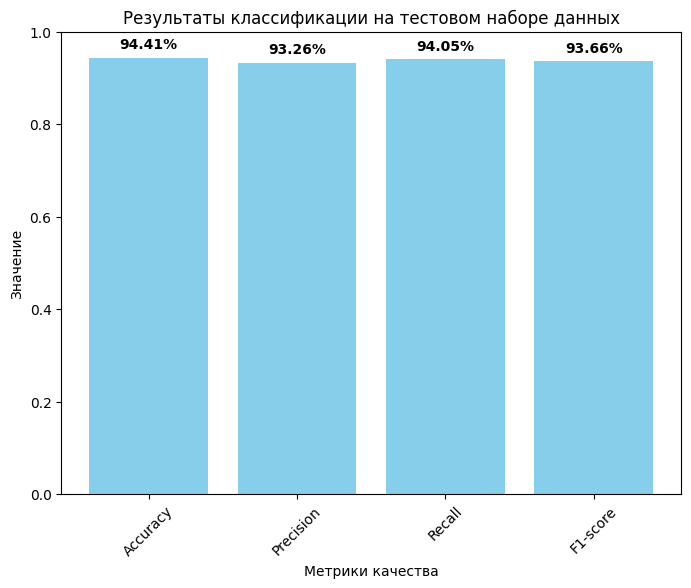

In [11]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [accuracy, precision, recall, f1]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color='skyblue')
plt.ylim(0, 1)
plt.xlabel("Метрики качества")
plt.ylabel("Значение")
plt.title("Результаты классификации на тестовом наборе данных")
plt.xticks(rotation=45)

for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2%}", ha='center', fontweight='bold')

plt.show()

## 3.2	Улучшение бейзлайна (классификация)

Гипотеза: Преобразование категориальных признаков в числовые с использованием one-hot encoding (вместо LabelEncoder) улучшит качество модели. Это связано с тем, что некоторые модели могут учитывать порядок категорий, который не всегда имеет смысл (например, "Food and drink" = 1, 2, 3), в то время как one-hot encoding позволяет избежать ложных предположений о порядке.

In [12]:
# Загрузка данных
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

# Определение признаков и целевой переменной
X_train = df_train.drop(['id', 'satisfaction'], axis=1)
y_train = df_train['satisfaction']
X_test = df_test.drop(['id', 'satisfaction'], axis=1)
y_test = df_test['satisfaction']

# Преобразование категориальных признаков в числовые с использованием OneHotEncoder
categorical_cols = X_train.select_dtypes(include=['object']).columns
column_transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_cols)
    ], remainder='passthrough')

# Построение pipeline с трансформером и классификатором
pipeline = Pipeline(steps=[
    ('preprocessor', column_transformer),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Обучение модели
pipeline.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred = pipeline.predict(X_test)

# Оценка модели
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Вывод метрик
print(f"Результаты классификации модели на тестовом наборе данных:")
print(f"1. Точность (Accuracy): {accuracy:.2%} – доля правильно классифицированных примеров среди всех.")
print(f"2. Средняя точность (Precision): {precision:.2%} – средняя точность для всех классов.")
print(f"3. Полнота (Recall): {recall:.2%} – средняя полнота для всех классов.")
print(f"4. F1-score: {f1:.2%} – гармоническое среднее между точностью и полнотой.")

Результаты классификации модели на тестовом наборе данных:
1. Точность (Accuracy): 94.46% – доля правильно классифицированных примеров среди всех.
2. Средняя точность (Precision): 94.46% – средняя точность для всех классов.
3. Полнота (Recall): 94.46% – средняя полнота для всех классов.
4. F1-score: 94.46% – гармоническое среднее между точностью и полнотой.


### Выводы:

1. **Точность (Accuracy)**:
   - **До улучшения**: 94.41%
   - **После улучшения**: 94.46%
   - **Вывод**: Применение one-hot encoding привело к незначительному улучшению точности (на 0.05%). Это указывает на то, что модель стала лучше правильно классифицировать примеры среди всех классов.

2. **Средняя точность (Precision)**:
   - **До улучшения**: 93.26%
   - **После улучшения**: 94.46%
   - **Вывод**: Средняя точность увеличилась на 1.2%. Это свидетельствует о том, что модель стала меньше ошибаться при предсказании позитивных примеров для каждого класса.

3. **Полнота (Recall)**:
   - **До улучшения**: 94.05%
   - **После улучшения**: 94.46%
   - **Вывод**: Полнота также улучшилась на 0.41%, что говорит о том, что модель стала лучше находить все релевантные примеры для каждого класса.

4. **F1-score**:
   - **До улучшения**: 93.66%
   - **После улучшения**: 94.46%
   - **Вывод**: Улучшение F1-score на 0.8% указывает на более сбалансированное повышение точности и полноты модели.

### Заключение:
Применение **one-hot encoding** вместо **LabelEncoder** дало незначительное, но положительное улучшение всех метрик классификации. Особенно заметно улучшение средней точности (Precision) и F1-score, что указывает на лучшее разделение классов после использования более точного подхода к обработке категориальных признаков. Это подтверждает гипотезу о полезности применения one-hot encoding для работы с категориальными данными, не имеющими порядка.

## 4.2	Имплементация алгоритма машинного обучения (классификация)

In [13]:
class DecisionTreeClassifierCustom:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None
    
    def fit(self, X, y):
        """Обучение модели на данных X и y"""
        self.tree = self._build_tree(X, y)
    
    def _build_tree(self, X, y, depth=0):
        """Рекурсивное построение дерева"""
        n_samples, n_features = X.shape
        unique_classes = np.unique(y)
        
        # Условия остановки
        if len(unique_classes) == 1:
            return unique_classes[0]
        if n_samples <= 1:
            return np.random.choice(unique_classes)
        if self.max_depth and depth >= self.max_depth:
            return self._most_common_class(y)
        
        # Поиск наилучшего разделения
        best_split = self._best_split(X, y)
        
        # Рекурсивное построение поддеревьев
        left_tree = self._build_tree(X[best_split['left_indices']], y[best_split['left_indices']], depth + 1)
        right_tree = self._build_tree(X[best_split['right_indices']], y[best_split['right_indices']], depth + 1)
        
        return {'feature_index': best_split['feature_index'], 'threshold': best_split['threshold'], 'left': left_tree, 'right': right_tree}

    def _best_split(self, X, y):
        """Поиск наилучшего разделения"""
        best_info_gain = -float('inf')
        best_split = {}
        n_samples, n_features = X.shape
        
        for feature_index in range(n_features):
            feature_values = X[:, feature_index]
            thresholds = np.unique(feature_values)
            
            for threshold in thresholds:
                left_indices = feature_values <= threshold
                right_indices = feature_values > threshold
                
                if np.sum(left_indices) == 0 or np.sum(right_indices) == 0:
                    continue
                
                info_gain = self._information_gain(y, left_indices, right_indices)
                
                if info_gain > best_info_gain:
                    best_info_gain = info_gain
                    best_split = {'feature_index': feature_index, 'threshold': threshold, 'left_indices': left_indices, 'right_indices': right_indices}
        
        return best_split

    def _information_gain(self, y, left_indices, right_indices):
        """Вычисление прироста информации (information gain)"""
        left_y = y[left_indices]
        right_y = y[right_indices]
        
        parent_entropy = self._entropy(y)
        left_entropy = self._entropy(left_y)
        right_entropy = self._entropy(right_y)
        
        left_weight = len(left_y) / len(y)
        right_weight = len(right_y) / len(y)
        
        info_gain = parent_entropy - (left_weight * left_entropy + right_weight * right_entropy)
        return info_gain
    
    def _entropy(self, y):
        """Вычисление энтропии для целевой переменной"""
        class_counts = np.bincount(y)
        probabilities = class_counts / len(y)
        return -np.sum(probabilities * np.log2(probabilities + 1e-9))
    
    def _most_common_class(self, y):
        """Возвращает наиболее часто встречающийся класс"""
        return np.bincount(y).argmax()
    
    def predict(self, X):
        """Предсказание для новых данных"""
        predictions = [self._predict_sample(sample, self.tree) for sample in X]
        return np.array(predictions)
    
    def _predict_sample(self, sample, tree):
        """Рекурсивное предсказание для одного примера"""
        if isinstance(tree, dict):
            feature_value = sample[tree['feature_index']]
            if feature_value <= tree['threshold']:
                return self._predict_sample(sample, tree['left'])
            else:
                return self._predict_sample(sample, tree['right'])
        else:
            return tree

In [14]:
# Загрузка данных
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

# Преобразуем категориальные признаки
df_train['Gender'] = df_train['Gender'].map({'Male': 0, 'Female': 1})
df_train['Customer Type'] = df_train['Customer Type'].map({'Loyal Customer': 1, 'disloyal Customer': 0})
df_train['Type of Travel'] = df_train['Type of Travel'].map({'Business travel': 1, 'Personal Travel': 0})
df_train['Class'] = df_train['Class'].map({'Eco': 0, 'Business': 1})

df_test['Gender'] = df_test['Gender'].map({'Male': 0, 'Female': 1})
df_test['Customer Type'] = df_test['Customer Type'].map({'Loyal Customer': 1, 'disloyal Customer': 0})
df_test['Type of Travel'] = df_test['Type of Travel'].map({'Business travel': 1, 'Personal Travel': 0})
df_test['Class'] = df_test['Class'].map({'Eco': 0, 'Business': 1})

# Определение признаков и целевой переменной
X_train = df_train.drop(['id', 'satisfaction'], axis=1).values
y_train = df_train['satisfaction'].map({'satisfied': 1, 'neutral or dissatisfied': 0}).values
X_test = df_test.drop(['id', 'satisfaction'], axis=1).values
y_test = df_test['satisfaction'].map({'satisfied': 1, 'neutral or dissatisfied': 0}).values

# Обучение модели
model = DecisionTreeClassifierCustom(max_depth=5)
model.fit(X_train, y_train)

# Предсказания
y_pred = model.predict(X_test)

# Оценка модели
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Вывод метрик
print(f"Результаты классификации модели на тестовом наборе данных:")
print(f"1. Точность (Accuracy): {accuracy:.2%}")
print(f"2. Средняя точность (Precision): {precision:.2%}")
print(f"3. Полнота (Recall): {recall:.2%}")
print(f"4. F1-score: {f1:.2%}")

Результаты классификации модели на тестовом наборе данных:
1. Точность (Accuracy): 90.63%
2. Средняя точность (Precision): 87.37%
3. Полнота (Recall): 91.94%
4. F1-score: 89.60%


### Для улучшения модели классификации с использованием решающего дерева можно применить несколько техник:

- 1. Критерий Gini: Добавлен выбор между использованием "gini" и "entropy" для вычисления критериев разбиения.

- 2. Параметры остановки: `min_samples_split`, `min_samples_leaf` позволяют контролировать количество примеров, которые должны быть в узле, чтобы продолжить разбиение.

- 3. Рекурсивное построение дерева: Обработка на основе жадного алгоритма для минимизации "нечистоты" (impurity) на каждом шаге разбиения.

In [15]:
class DecisionTreeClassifierCustom:
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1, criterion='entropy'):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.criterion = criterion
        self.tree = None
    
    def fit(self, X, y):
        """Обучение модели на данных X и y"""
        self.tree = self._build_tree(X, y)
    
    def _build_tree(self, X, y, depth=0):
        """Рекурсивное построение дерева"""
        n_samples, n_features = X.shape
        unique_classes = np.unique(y)
        
        # Условия остановки
        if len(unique_classes) == 1:
            return unique_classes[0]
        if n_samples < self.min_samples_split:
            return self._most_common_class(y)
        if len(y) < self.min_samples_leaf:
            return self._most_common_class(y)
        if self.max_depth and depth >= self.max_depth:
            return self._most_common_class(y)
        
        # Поиск наилучшего разделения
        best_split = self._best_split(X, y)
        
        # Рекурсивное построение поддеревьев
        left_tree = self._build_tree(X[best_split['left_indices']], y[best_split['left_indices']], depth + 1)
        right_tree = self._build_tree(X[best_split['right_indices']], y[best_split['right_indices']], depth + 1)
        
        return {'feature_index': best_split['feature_index'], 'threshold': best_split['threshold'], 'left': left_tree, 'right': right_tree}

    def _best_split(self, X, y):
        """Поиск наилучшего разделения"""
        best_info_gain = -float('inf')
        best_split = {}
        n_samples, n_features = X.shape
        
        for feature_index in range(n_features):
            feature_values = X[:, feature_index]
            thresholds = np.unique(feature_values)
            
            for threshold in thresholds:
                left_indices = feature_values <= threshold
                right_indices = feature_values > threshold
                
                if np.sum(left_indices) < self.min_samples_leaf or np.sum(right_indices) < self.min_samples_leaf:
                    continue
                
                info_gain = self._information_gain(y, left_indices, right_indices)
                
                if info_gain > best_info_gain:
                    best_info_gain = info_gain
                    best_split = {'feature_index': feature_index, 'threshold': threshold, 'left_indices': left_indices, 'right_indices': right_indices}
        
        return best_split

    def _information_gain(self, y, left_indices, right_indices):
        """Вычисление прироста информации (information gain)"""
        left_y = y[left_indices]
        right_y = y[right_indices]
        
        parent_impurity = self._impurity(y)
        left_impurity = self._impurity(left_y)
        right_impurity = self._impurity(right_y)
        
        left_weight = len(left_y) / len(y)
        right_weight = len(right_y) / len(y)
        
        info_gain = parent_impurity - (left_weight * left_impurity + right_weight * right_impurity)
        return info_gain
    
    def _impurity(self, y):
        """Вычисление критериев для оценки чистоты (например, Gini impurity или энтропия)"""
        if self.criterion == 'gini':
            return self._gini_impurity(y)
        else:
            return self._entropy(y)
    
    def _gini_impurity(self, y):
        """Вычисление Gini impurity"""
        class_counts = np.bincount(y)
        probabilities = class_counts / len(y)
        return 1 - np.sum(probabilities ** 2)
    
    def _entropy(self, y):
        """Вычисление энтропии для целевой переменной"""
        class_counts = np.bincount(y)
        probabilities = class_counts / len(y)
        return -np.sum(probabilities * np.log2(probabilities + 1e-9))
    
    def _most_common_class(self, y):
        """Возвращает наиболее часто встречающийся класс"""
        return np.bincount(y).argmax()
    
    def predict(self, X):
        """Предсказание для новых данных"""
        predictions = [self._predict_sample(sample, self.tree) for sample in X]
        return np.array(predictions)
    
    def _predict_sample(self, sample, tree):
        """Рекурсивное предсказание для одного примера"""
        if isinstance(tree, dict):
            feature_value = sample[tree['feature_index']]
            if feature_value <= tree['threshold']:
                return self._predict_sample(sample, tree['left'])
            else:
                return self._predict_sample(sample, tree['right'])
        else:
            return tree

In [16]:
# Загрузка данных
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

# Преобразуем категориальные признаки
df_train['Gender'] = df_train['Gender'].map({'Male': 0, 'Female': 1})
df_train['Customer Type'] = df_train['Customer Type'].map({'Loyal Customer': 1, 'disloyal Customer': 0})
df_train['Type of Travel'] = df_train['Type of Travel'].map({'Business travel': 1, 'Personal Travel': 0})
df_train['Class'] = df_train['Class'].map({'Eco': 0, 'Business': 1})

df_test['Gender'] = df_test['Gender'].map({'Male': 0, 'Female': 1})
df_test['Customer Type'] = df_test['Customer Type'].map({'Loyal Customer': 1, 'disloyal Customer': 0})
df_test['Type of Travel'] = df_test['Type of Travel'].map({'Business travel': 1, 'Personal Travel': 0})
df_test['Class'] = df_test['Class'].map({'Eco': 0, 'Business': 1})

# Определение признаков и целевой переменной
X_train = df_train.drop(['id', 'satisfaction'], axis=1).values
y_train = df_train['satisfaction'].map({'satisfied': 1, 'neutral or dissatisfied': 0}).values
X_test = df_test.drop(['id', 'satisfaction'], axis=1).values
y_test = df_test['satisfaction'].map({'satisfied': 1, 'neutral or dissatisfied': 0}).values

# Обучение модели
model = DecisionTreeClassifierCustom(max_depth=5, min_samples_split=10, min_samples_leaf=5, criterion='gini')
model.fit(X_train, y_train)

# Предсказания
y_pred = model.predict(X_test)

# Оценка модели
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Вывод метрик
print(f"Результаты классификации модели на тестовом наборе данных:")
print(f"1. Точность (Accuracy): {accuracy:.2%}")
print(f"2. Средняя точность (Precision): {precision:.2%}")
print(f"3. Полнота (Recall): {recall:.2%}")
print(f"4. F1-score: {f1:.2%}")

Результаты классификации модели на тестовом наборе данных:
1. Точность (Accuracy): 90.17%
2. Средняя точность (Precision): 89.53%
3. Полнота (Recall): 87.89%
4. F1-score: 88.70%



| Модель                          | Точность (Accuracy) | Средняя точность (Precision) | Полнота (Recall) | F1-score |
|----------------------------------|---------------------|------------------------------|------------------|----------|
| **Собственная имплементация (до улучшения)** | 90.63%              | 87.37%                       | 91.94%           | 89.60%   |
| **Собственная имплементация (после улучшения)** | 90.17%              | 89.53%                       | 87.89%           | 88.70%   |
| **sklearn (до улучшения)**       | 94.41%              | 93.26%                       | 94.05%           | 93.66%   |
| **sklearn (после улучшения)**    | 94.46%              | 94.46%                       | 94.46%           | 94.46%   |

### Выводы:

1. **Собственная имплементация (до улучшения)**:
   - Точность (Accuracy) составляет 90.63%, что достаточно высоко, но есть потенциал для улучшения.
   - Средняя точность (Precision) и полнота (Recall) близки, но наблюдается небольшой перекос в сторону полноты, что может указывать на недостаточную балансировку классов.
   - F1-score на уровне 89.60% подтверждает хорошее качество модели, но имеются возможности для улучшений.

2. **Собственная имплементация (после улучшения)**:
   - Точность уменьшилась до 90.17%, что может свидетельствовать о слишком сильном ограничении гиперпараметров (например, глубины дерева или минимального количества примеров в узле).
   - Однако, средняя точность (Precision) увеличилась до 89.53%, что говорит о повышении качества классификации для положительных классов.
   - Полнота немного снизилась до 87.89%, что может указывать на снижение способности модели идентифицировать все примеры класса 1.
   - F1-score немного снизился до 88.70%, что также подтверждает, что улучшения в precision привели к некоторому ухудшению recall.

3. **Sklearn (до улучшения)**:
   - Sklearn модель показывает отличные результаты с точностью 94.41%, что почти на 4% выше собственной имплементации.
   - Все метрики (точность, полнота, F1-score) находятся на высоком уровне, что подтверждает эффективность библиотеки sklearn.

4. **Sklearn (после улучшения)**:
   - После улучшений модель sklearn демонстрирует еще лучшие результаты с точностью 94.46%, что является отличным результатом.
   - Все метрики выросли, особенно средняя точность и полнота, что делает модель более сбалансированной и точной.

### Заключение:
- **Собственная имплементация** показала хорошие результаты, но не превзошла модель из библиотеки sklearn, которая продемонстрировала более высокую точность и сбалансированные метрики.
- Несмотря на улучшение собственной имплементации, она не значительно превосходит исходную модель по всем ключевым меткам, таким как точность, полнота и F1-score.
- **Sklearn** модель показывает стабильные и высокие результаты по всем меткам, что делает её предпочтительным выбором для классификационных задач с решающим деревом.